# Imports

In [1]:
import os
import numpy as np
import torch
from PIL import Image

import torchvision
import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils

## Dataset Class Definition

In [2]:
class PennFundanPedDataSet(object):

    """
    The dataset class of the PennFundan Pedestrian set
    """

    def __init__(self, root, transforms):
        
        self.root = root
        self.transforms = transforms
        self.images = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        self.annotations = list(
            sorted(os.listdir(os.path.join(root, "Annotation"))))

    def __len__(self):
        
        return len(self.images)

    
    def __getitem__(self, idx):

        # load images, masks and annotation paths
        img_path = os.path.join(self.root, "PNGImages", self.images[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        annotation_path = os.path.join(
            self.root, "Annotations", self.masks[idx])

        # Opening the images and masks
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Convert the mask to an array, where each value can be considered an id.. ex:
        # 0 : Is a pixel that belongs to the background // Which we remove.
        # 1 : Is a pixel that belongs to detected person number 1
        # ... and every othe integer idntifies a different unique person
        mask = np.array(mask)
        obj_ids = np.unique(mask)[1:]

        # Use numpy broadcasting to seperate the masks,
        # It's basically like creating an array of masks where each
        # layer from the array represents a different mask
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)

        # Create boxes around the detected people by getting the min and max x,y
        # positions from the masks for each mask
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones(num_objs, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        is_crowd = torch.zeros(num_objs, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = is_crowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

## Training Class

In [3]:
class ModelTraining():

    def __init__(self):
        # train on the GPU
        self.device = torch.device('cuda')

        # Dataset has two classes only - background and person
        num_classes = 2

        dataset = PennFundanPedDataSet(
            'PennFudanPed', self.get_transform(train=True))
        dataset_test = PennFundanPedDataSet(
            'PennFudanPed', self.get_transform(train=False))
        indices = torch.randperm(len(dataset)).tolist()

        self.dataset = torch.utils.data.Subset(dataset, indices[:-50])
        self.dataset_test = torch.utils.data.Subset(
            dataset_test, indices[-50:])

        self.data_loader = torch.utils.data.DataLoader(
            self.dataset, batch_size=2, shuffle=True, num_workers=4,
            collate_fn=utils.collate_fn)

        self.data_loader_test = torch.utils.data.DataLoader(
            self.dataset_test, batch_size=1, shuffle=False, num_workers=4,
            collate_fn=utils.collate_fn)

        self.model = self.get_model_instance_segmentation(num_classes)

        self.model.to(self.device)

        # construct an optimizer
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.SGD(
            params, lr=0.005, momentum=0.9, weight_decay=0.0005)

        # construct a learning rate scheduler
        self.lr_scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=3, gamma=0.1)

    def start_training(self, num_epochs=10):
        """
        Call this method to start training the model
        """

        for epoch in range(num_epochs):
            # train for one epoch, printing every 10 iterations
            train_one_epoch(self.model, self.optimizer, self.data_loader,
                            self.device, epoch, print_freq=10)
            # update the learning rate
            self.lr_scheduler.step()
            # evaluate on the test dataset
            evaluate(self.model, self.data_loader_test, device=self.device)

            # Save the model parameters after each epoch
            if not os.path.exists('./Saved Parameters'):
                os.mkdir('./Saved Parameters')
            torch.save(self.model.state_dict(),
                       f'./Saved Parameters/SavedParameters after epoch {epoch}')

        print("Done")

    def load_model_parameters(self, file_path):
        """
        Load model parameters from a local file location
        """
        try:
            self.model.load_state_dict(torch.load(file_path))
        except:
            print("The file location may be incorrect")

    def get_model_instance_segmentation(self, num_classes):
        """
        Returns a modified pretrained maskrcnn_resnet50 model, finetuned to our specific classes
        """
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(
            pretrained=True)

        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(
            in_features, num_classes)

        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256

        model.roi_heads.mask_predictor = MaskRCNNPredictor(
            in_features_mask, hidden_layer, num_classes)

        return model

    def get_transform(self, train):
        """
        Make a random horizontal flip to the given data, (train) is a flag that enables this transformation
        """
        transforms = []
        transforms.append(T.ToTensor())
        if train:
            transforms.append(T.RandomHorizontalFlip(0.5))
        return T.Compose(transforms)

    def get_model(self):
        return self.model

    def get_random_prediction(self):
        # pick one image from the test set
        img, _ = self.dataset_test[0]
        # put the model in evaluation mode
        self.model.eval()
        with torch.no_grad():
            prediction = self.model([img.to(self.device)])
        return img, prediction

## Paintshop class (Responsible for visualizing the predictions)

In [16]:
class PaintShop():
    def __init__(self, image, prediction):
        self.image = image.mul(255).permute(1, 2, 0).byte().numpy()
        self.prediction = prediction
        self.scores = prediction[0]['scores'].cpu().numpy()
        self.boxes = prediction[0]['boxes'].int()
        self.masks = prediction[0]['masks']
        self.predicted_count = np.size(np.where(self.scores > 0.5))

    def draw_bounding_boxes(self, show=True):
        """
        Draw the image with drawn bounding boxes around subjects
        """
        image = self.image
        x1, x2, y1, y2 = 0, 0, 0, 0

        for i in range(self.predicted_count):
            x1 = self.boxes[i][0].item()
            x2 = self.boxes[i][2].item()
            y1 = self.boxes[i][1].item()
            y2 = self.boxes[i][3].item()

            for j in range(3):
                image[y1:y1+2, x1:x2, j] = self.get_color(i)[j]  # top border
                # bottom border
                image[y2-2:y2, x1:x2, j] = self.get_color(i)[j]
                image[y1:y2, x1:x1+2, j] = self.get_color(i)[j]  # left border
                image[y1:y2, x2-2:x2, j] = self.get_color(i)[j]  # right border
        if show:
            Image.fromarray(image).show()
        return image

    def draw_masks(self, show=True):
        """
        Draw the masks only on the image
        """
        masks = self.masks
        for i in range(self.predicted_count):
            mask = masks[i, 0].mul(255).cpu().byte().numpy()
            mask = mask[:, :, np.newaxis]
            mask = np.repeat(mask, repeats=3, axis=2,)
            for j in range(3):
                mask[:, :, j] = np.where(
                    mask[:, :, j] > 160, self.get_color(i)[j], mask[:, :, j])
            if (i == 0):
                final = mask
            else:
                final = final + mask
        if show:
            Image.fromarray(final).show()
        return final

    def draw_everything(self, show):
        """
        Draw the bounding boxes above the masks
        """
        everything = np.concatenate(
            (self.draw_bounding_boxes(False), self.draw_masks(False)), axis=0)
        if show:
            Image.fromarray(everything).show()
        return everything

    def get_color(self, idx):
        """
        Returns a list of RGB color 
        """
        colors = {
            5: [154, 89, 181],
            3: [52, 152, 219],
            2: [46, 204, 113],
            1: [231, 76, 60],
            4: [230, 126, 34],
            0: [241, 196, 15],
            6: [59, 59, 152],
            7: [24, 44, 97],
            8: [236, 240, 241]

        }

        return colors[idx]


## The main function

In [21]:
main_model = ModelTraining()

# The next commented line is for training the model from the begining 

# main_model.start_training()

# Here we load the model parameteres we reached after 10th epoch    
# If you wish to use it
# Please copy the file to the file from "Saved_Dict_after_10th_epoch" to the designated "Saved Parameters" folder 

main_model.load_model_parameters(
    file_path=f"Saved Parameters/Saved model params after epoch 10")
image,prediction= main_model.get_random_prediction()

## Creating a painter instance that can either show the mask, image with boxes, or both

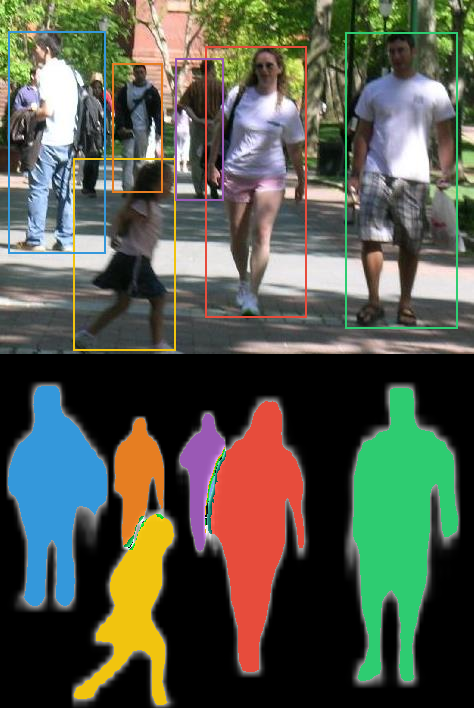

In [22]:
painter = PaintShop(image,prediction)
# mask_only = painter.draw_masks(show=True) ## This can show only the mask image
# bounding_box = painter.draw_bounding_boxes(show = True) ## This can show only the bounding box around objects in the image
required_output = painter.draw_everything(show=True)
Image.fromarray(required_output)